<a href="https://colab.research.google.com/github/Denuwanhh/neural-network-notebooks/blob/main/lstm-time-series/lstm_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [78]:
import pandas as pd
import numpy as np
import joblib
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [79]:
# Load and preprocess data
file_path = "/content/gold-price-2010-2024.csv"
data = pd.read_csv(file_path)
data['Date'] = pd.to_datetime(data['Date'])
data = data.sort_values(by='Date').reset_index(drop=True)

data

,Currency,Date,Exchange Rate
0,XAU,2010-05-07,136459.7395
1,XAU,2010-05-11,136684.5647
2,XAU,2010-05-12,139577.2499
3,XAU,2010-05-13,140790.1394
4,XAU,2010-05-14,140514.5200
...,...,...,...
3073,XAU,2024-12-23,769713.5684
3074,XAU,2024-12-24,773996.5414
3075,XAU,2024-12-26,778557.7168
3076,XAU,2024-12-27,774237.5461


In [80]:
# Normalize exchange rate
exchange_rates = data['Exchange Rate'].values
scaler = MinMaxScaler(feature_range=(0, 1))
exchange_rates_scaled = scaler.fit_transform(exchange_rates.reshape(-1, 1))

exchange_rates_scaled

array([[0.00742569],
       [0.00775412],
       [0.01197981],
       ...,
       [0.94541523],
       [0.93910424],
       [0.93047611]])

In [81]:
# Split data
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [82]:
# Reshape for LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [83]:
# Save scaler
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [84]:
# Step 2: Create Time Series Sequences
def create_sequences(data, window_size):
    sequences = []
    labels = []
    for i in range(len(data) - window_size):
        sequences.append(data[i:i + window_size])
        labels.append(data[i + window_size])
    return np.array(sequences), np.array(labels)

window_size = 15
X, y = create_sequences(exchange_rates_scaled, window_size)

In [85]:
# Step 3: Split Data into Training and Testing Sets
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape data for LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Step 4: Build the LSTM Model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25, activation='relu'),
    Dense(1)  # Predict a single value
])

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Display the model summary
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                       │ (None, 15, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 15, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_11 (LSTM)                       │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 25)                  │           1,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,901 (124.61 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

In [86]:
# Step 5: Train the Model
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)

history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
                    epochs=100, batch_size=10, verbose=1, callbacks=[early_stopping, lr_scheduler])

Epoch 1/100
245/245 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.0055 - val_loss: 5.4157e-04 - learning_rate: 0.0100
Epoch 2/100
245/245 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0015 - val_loss: 0.0023 - learning_rate: 0.0100
Epoch 3/100
245/245 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 7.3942e-04 - val_loss: 0.0080 - learning_rate: 0.0100
Epoch 4/100
245/245 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 6.7654e-04 - val_loss: 4.3998e-04 - learning_rate: 0.0100
Epoch 5/100
245/245 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 7.5047e-04 - val_loss: 0.0169 - learning_rate: 0.0100
Epoch 6/100
245/245 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 9.7605e-04 - val_loss: 0.0075 - learning_rate: 0.0100
Epoch 7/100
245/245 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 7.9936e-04 - val_loss: 0.0015 - learning_rate: 0.0100
Epoch 8/100
245/245 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 6.1304e-04 - val_loss: 4.6061e-04 - learning_rate: 0.0100
Epoch 9/100
245/245 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 7.0204

In [87]:
# Step 6: Evaluate the Model
test_loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")

#Test Loss: 0.0003850847715511918
#Test Loss: 0.00028306085732765496
#Test Loss: 0.00017716320871841162
#Test Loss: 0.00017991021741181612

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.8977e-04
Test Loss: 0.00018937412824016064


In [88]:
# Step 7: Make Predictions
predicted_prices = model.predict(X_test)

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


In [89]:
# Inverse transform predictions and test data
scaler = joblib.load('scaler.pkl')  # Load the saved scaler
predicted_prices = scaler.inverse_transform(predicted_prices)
actual_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

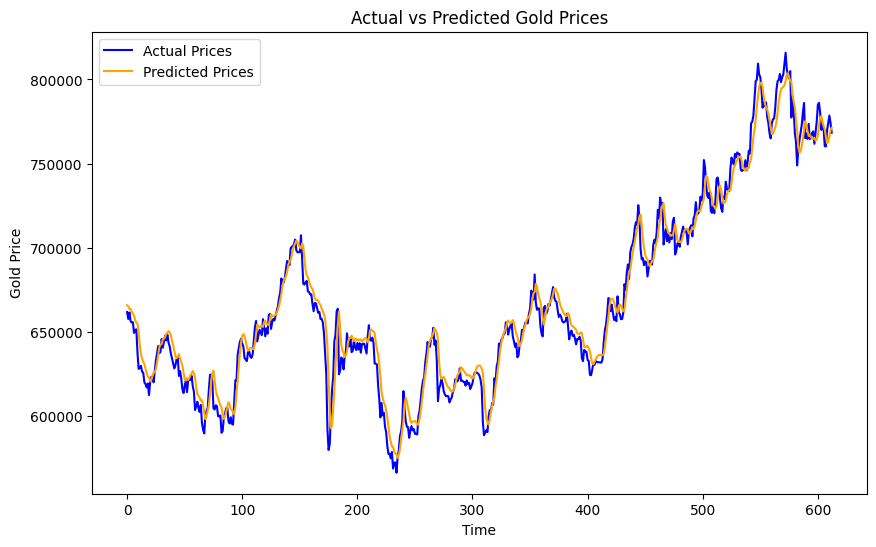

In [90]:
# Step 8: Visualize the Results
plt.figure(figsize=(10, 6))
plt.plot(range(len(actual_prices)), actual_prices, label="Actual Prices", color='blue')
plt.plot(range(len(predicted_prices)), predicted_prices, label="Predicted Prices", color='orange')
plt.title("Actual vs Predicted Gold Prices")
plt.xlabel("Time")
plt.ylabel("Gold Price")
plt.legend()
plt.show()

In [91]:
# Step 9: Save the Model (Optional)
model.save('gold_price_prediction_model_1.h5')
print("Model saved successfully!")

Model saved successfully!


In [92]:
from tensorflow.keras.models import load_model
import joblib
import numpy as np

# Load the saved model and scaler
model = load_model('gold_price_prediction_model_1.h5')
scaler = joblib.load('scaler.pkl')

# Replace with the most recent 30 days of gold prices (example values)
recent_prices = np.array([763459.5484,
768331.1874,
774237.5461,
778557.7168,
773996.5414,
769713.5684,
760126.4750,
760289.8220,
770447.0764,
772684.3983,
769980.1445,
780230.8665,
786061.4182,
784952.1604,
774768.0040,
768621.0530])  # Add last 30 days' prices

recent_prices = np.flip(recent_prices)

# Preprocess the input data
recent_prices_scaled = scaler.transform(recent_prices.reshape(-1, 1))
input_data = recent_prices_scaled.reshape((1, len(recent_prices_scaled), 1))

# Predict tomorrow's price
predicted_price_scaled = model.predict(input_data)
predicted_price = scaler.inverse_transform(predicted_price_scaled)

# Print the result
print(f"Predicted Gold Price for Tomorrow: {predicted_price[0][0]}")

#Predicted Gold Price for Tomorrow: 764529.9375

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step
Predicted Gold Price for Tomorrow: 766610.6875
